In [10]:
import seaborn as sea
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KernelDensity
import numpy as py
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [11]:
file_name = '../measurements_java.csv'        
df = pd.read_csv(file_name, header = 0, delimiter=",", decimal=".", names=['Language','Program','PowerLimit','Package','Core','GPU','DRAM','Time','Temperature','Memory'])
print(df.describe())

       PowerLimit     Package        Core           Time  Temperature  \
count  600.000000  600.000000  600.000000     600.000000   600.000000   
mean    34.833333  218.601695  169.235243   13984.868333    49.939000   
std     39.446998  162.947871  138.143625   17184.014524     7.445785   
min     -1.000000   45.020752   19.611328    2506.000000    38.300000   
25%      5.000000   93.455002   71.991898    5887.500000    42.400000   
50%     22.500000  183.010101  124.129761    8827.000000    51.450000   
75%     45.000000  285.548584  203.377136   15252.500000    55.100000   
max    115.000000  703.172974  625.232849  127049.000000    67.800000   

             Memory  
count  6.000000e+02  
mean   8.035004e+05  
std    4.580640e+05  
min    1.062880e+05  
25%    4.671830e+05  
50%    7.742880e+05  
75%    1.079808e+06  
max    1.816748e+06  


#### Comparar PowerLimit e Package só do avrora

<Axes: xlabel='PowerLimit', ylabel='Package'>

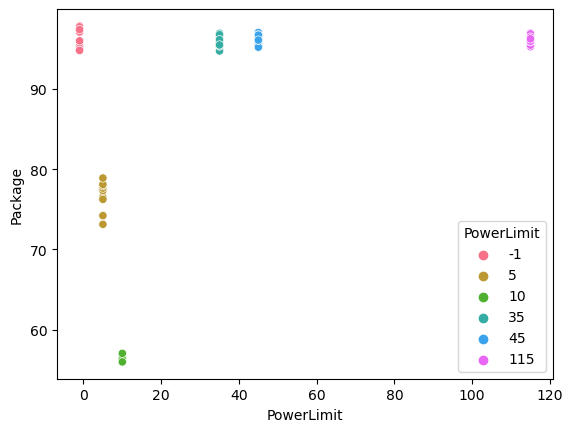

In [12]:
# Filter the DataFrame for one specific program (e.g., 'real/grep')
program_df = df[df['Program'] == ' avrora']

custom_palette = sea.color_palette("husl", n_colors=len(program_df['PowerLimit'].unique()))

# Create the scatterplot
sea.scatterplot(data=program_df, hue='PowerLimit', x='PowerLimit', y='Package', palette=custom_palette)
# program_df


#### Comparar PowerLimit e Package de todos

<Axes: xlabel='PowerLimit', ylabel='Package'>

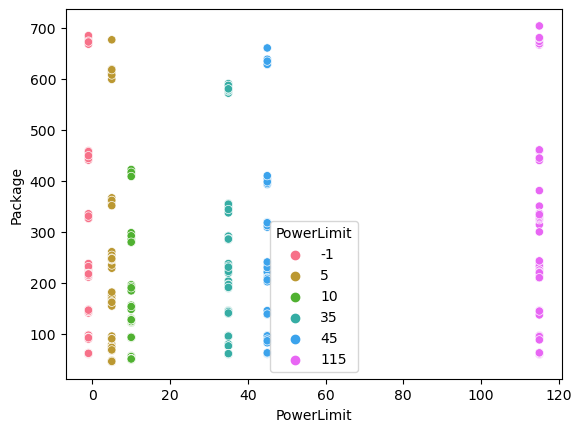

In [13]:
# Filter the DataFrame for one specific program (e.g., 'real/grep')
custom_palette = sea.color_palette("husl", n_colors=len(program_df['PowerLimit'].unique()))

# Create the scatterplot
sea.scatterplot(data=df, hue='PowerLimit', x='PowerLimit', y='Package', palette=custom_palette)
# program_df

#### Box Plots para todos os benchmarks

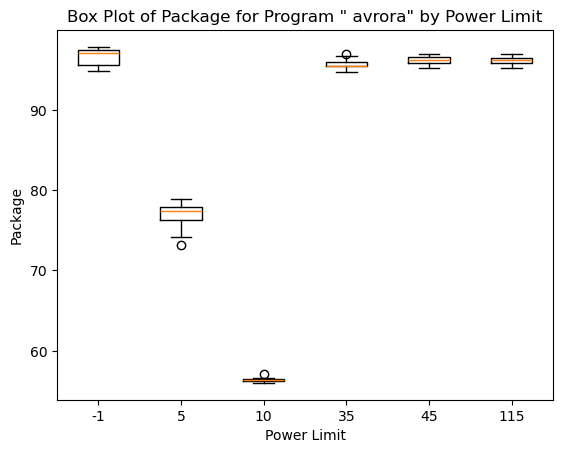

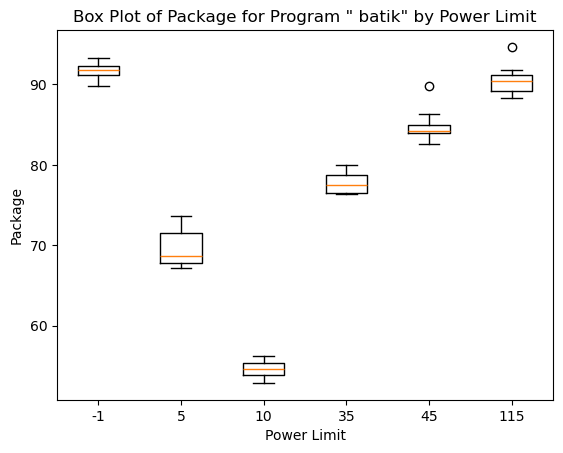

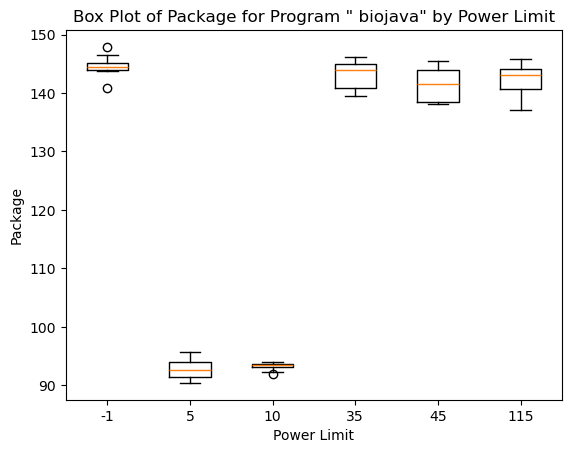

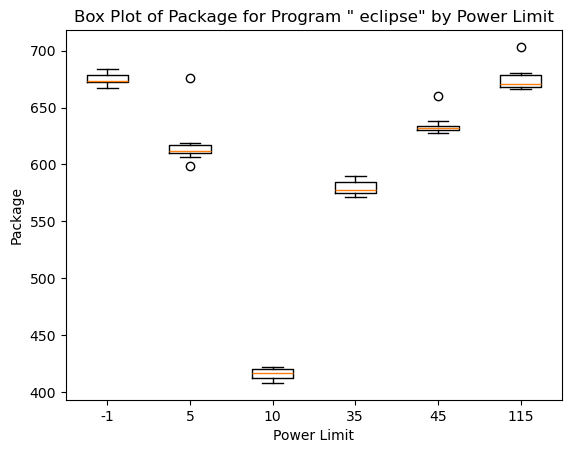

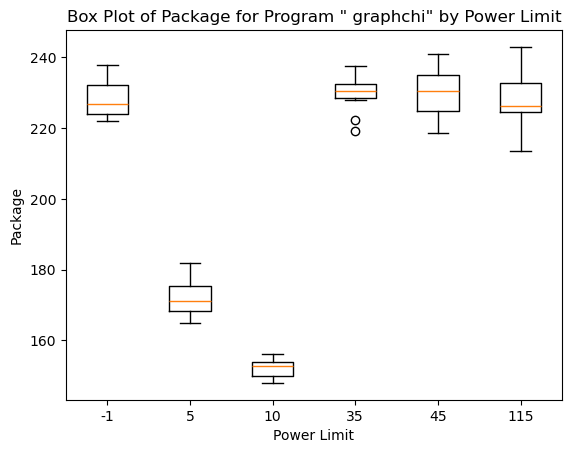

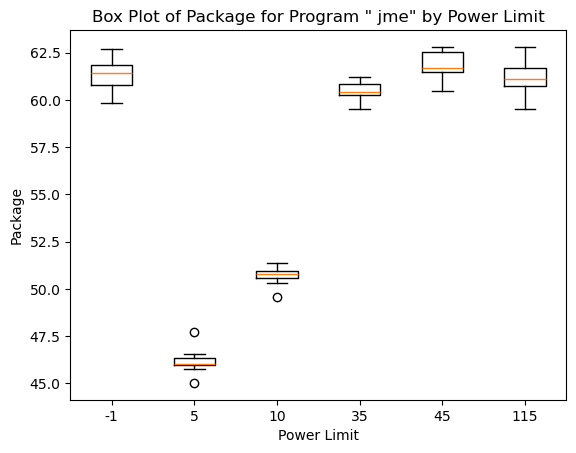

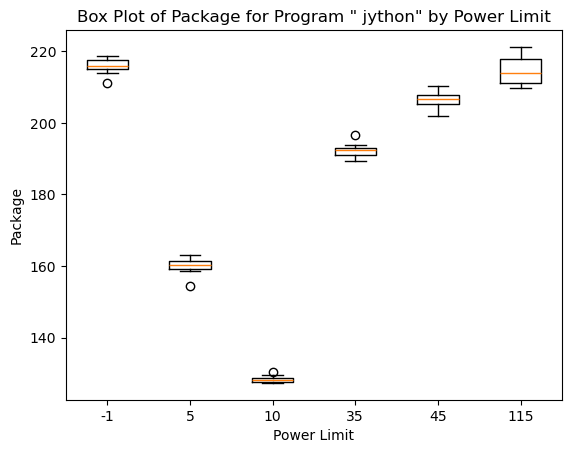

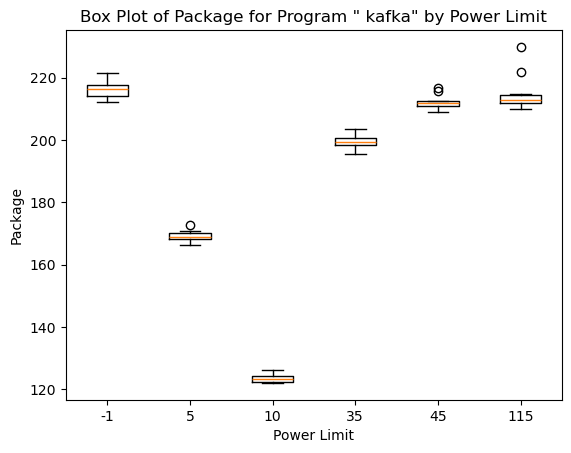

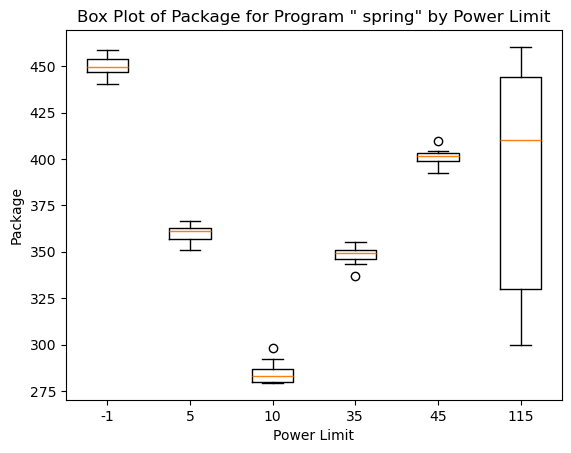

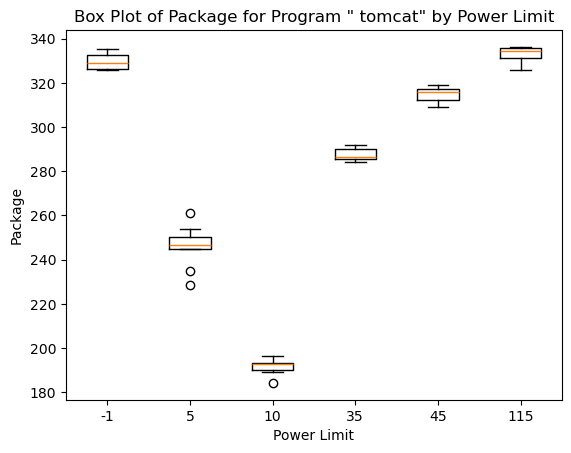

In [14]:
# Iterate over each program group
groups = df.groupby('Program')
def show_box_plot(groups):
    for name, program_group in groups:
        # Group the program group by power limit
        power_groups = program_group.groupby('PowerLimit')
        
        # Create an empty list to store the data for each power limit
        data = []
        
        # Extract data for each power limit and store it in the list
        for power, power_group in power_groups:
            data.append(power_group['Package'])
        
        
        # Create a box plot for each power limit for the current program
        plt.boxplot(data, labels=power_groups.groups.keys())
        plt.xlabel('Power Limit')
        plt.ylabel('Package')
        plt.title(f'Box Plot of Package for Program "{name}" by Power Limit')
        plt.show()

show_box_plot(groups)

In [15]:
grouped_df = df.groupby(['Program', 'PowerLimit'])

def remove_outliers(group):
    Q1 = group['Time'].quantile(0.25)
    Q3 = group['Time'].quantile(0.75)
    IQR = Q3 - Q1
    mask = (group['Time'] >= (Q1 - 1.5 * IQR)) & (group['Time'] <= (Q3 + 1.5 * IQR))
    return group[mask]


cleaned_df = grouped_df.apply(remove_outliers).reset_index(drop=True)
#groups = cleaned_df.groupby('Program')
#show_box_plot(groups)

#### Density Estimation

<Axes: xlabel='Package', ylabel='Count'>

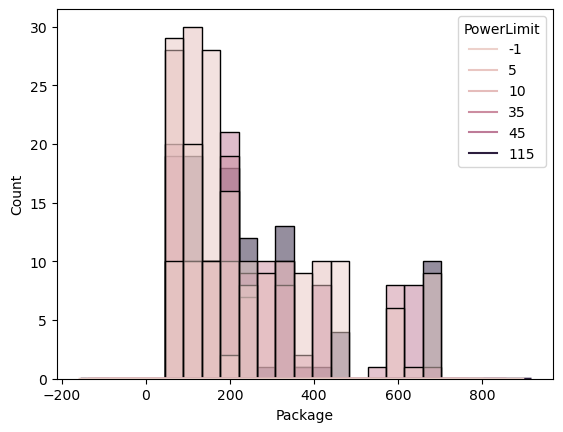

In [16]:
sea.histplot(data=cleaned_df, hue='PowerLimit', x='Package')
sea.kdeplot(data=cleaned_df, hue='PowerLimit', x='Package')

## Correlação entre Variáveis

##### real_gg (sem powercap -1, se não o gráfico fica errado)

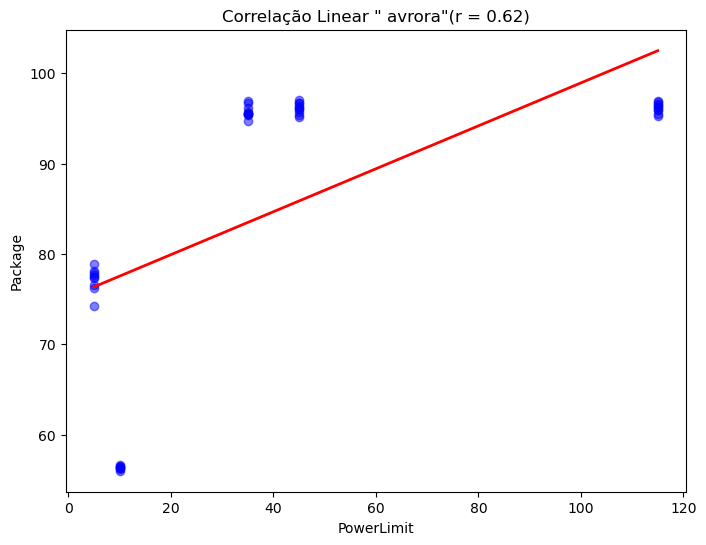

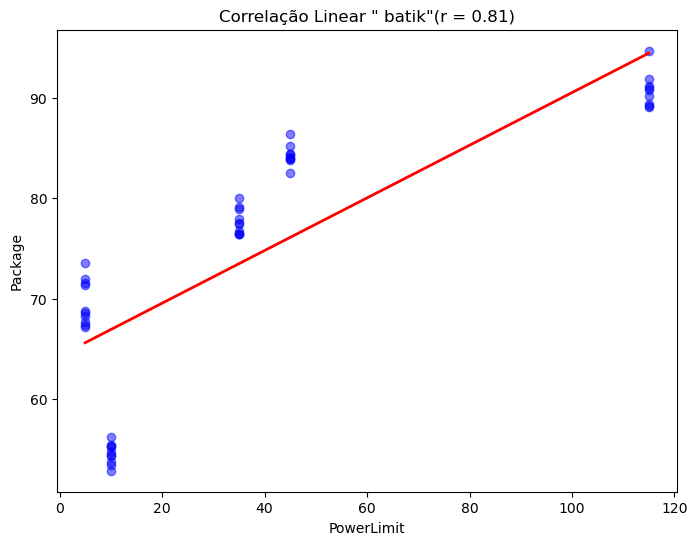

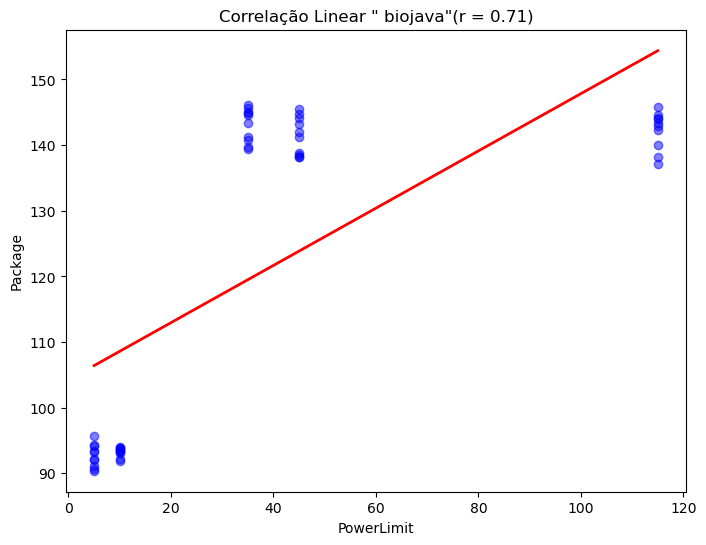

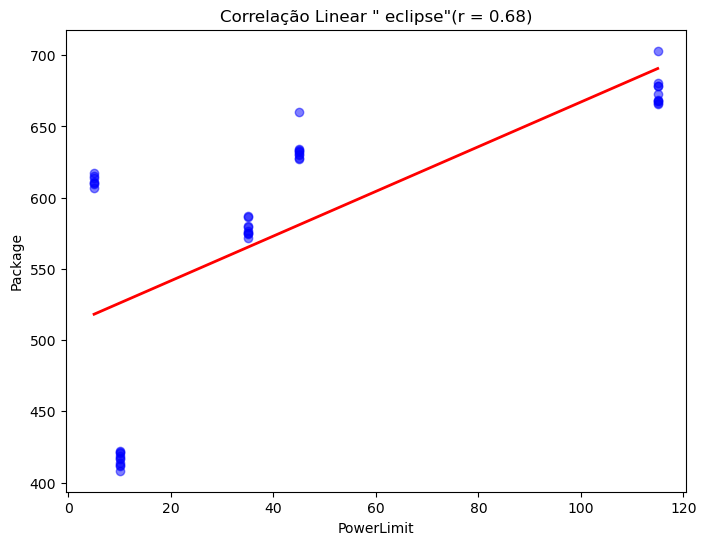

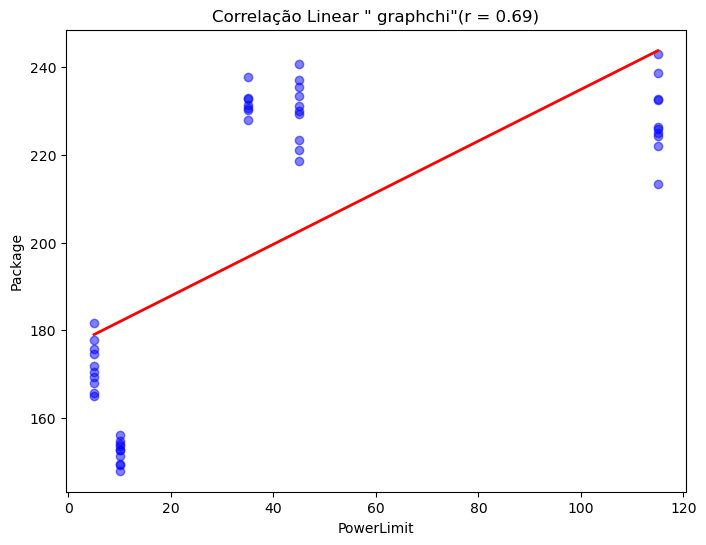

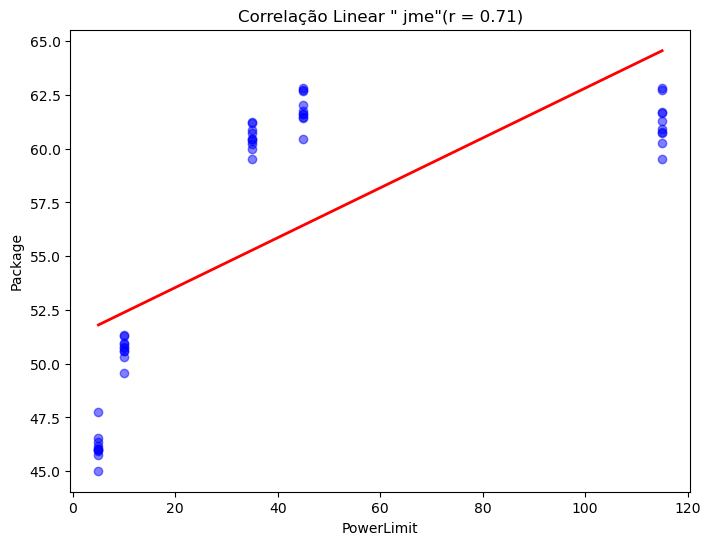

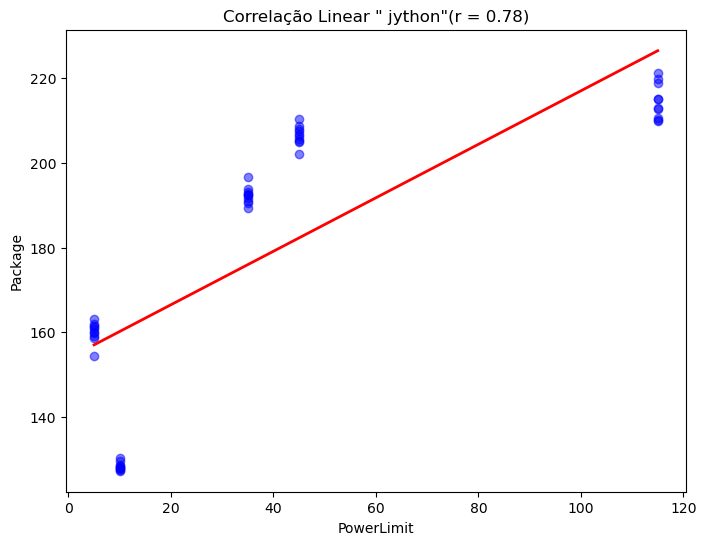

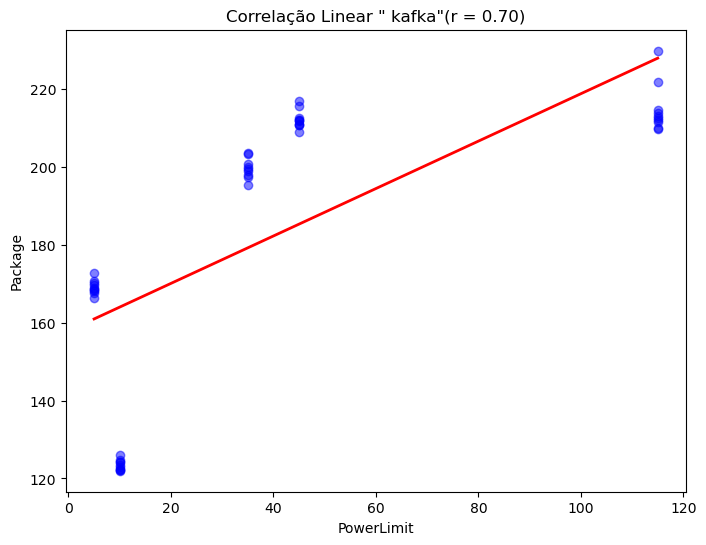

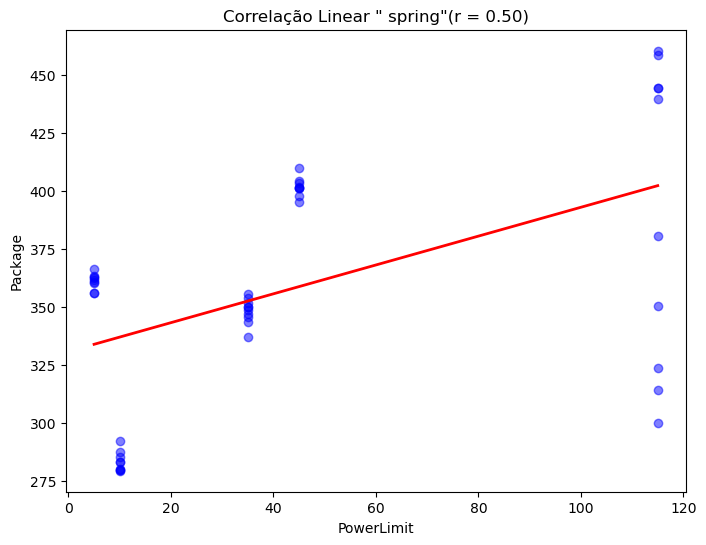

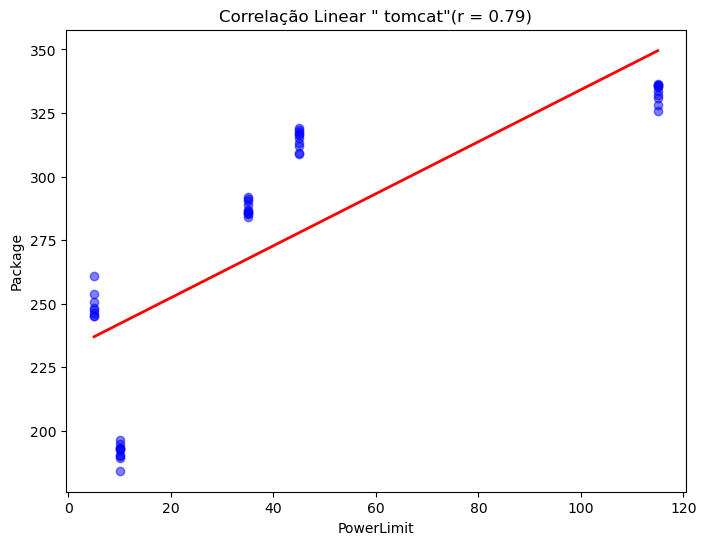

In [17]:
#file_nameh1 = 'measurements_haskell.csv'        
#dfh1 = pd.read_csv(file_nameh1, header = 0, delimiter=",", decimal=".", names=['Language','Program','PowerLimit','Package','Core','GPU','DRAM','Time','Temperature','Memory'])
cleaned_df2 = cleaned_df
dfh1 = cleaned_df2[cleaned_df2['PowerLimit'] != -1]
groups = dfh1.groupby('Program')


def show_corr_linear(groups):
    for name, program_group in groups:

        

        # Criando o gráfico de dispersão
        plt.figure(figsize=(8, 6))
        plt.scatter(program_group['PowerLimit'], program_group['Package'], color='blue', alpha=0.5)

        # Adicionando a linha de regressão linear
        slope, intercept, r_value, p_value, std_err = stats.linregress(program_group['PowerLimit'], program_group['Package'])
        plt.plot(program_group['PowerLimit'], slope * program_group['PowerLimit'] + intercept, color='red', linewidth=2)

        plt.xlabel('PowerLimit')
        plt.ylabel('Package')
        plt.title(f'Correlação Linear "{name}"(r = '+'{:.2f})'.format(r_value))
        plt.show()


show_corr_linear(groups)


### Teste de 1. **Pearson**

In [18]:
def calculate_correlations(group):
    # 1. **Pearson** correlation
    Pearson_corr, Pearson_p = stats.pearsonr(group['Time'], group['PowerLimit'])
    
    # **Spearman** correlation
    Spearman_corr, Spearman_p = stats.spearmanr(group['Time'], group['PowerLimit'])
    
    # 3. **Kendall** Tau correlation
    Kendall_corr, Kendall_p = stats.kendalltau(group['Time'], group['PowerLimit'])
    
    # Return results in a DataFrame format for easier concatenation
    return pd.DataFrame({
        'Program': [group['Program'].iloc[0]],
        'Pearson': [Pearson_corr],
        'Pearson_p': [Pearson_p],
        'Spearman': [Spearman_corr],
        'Spearman_p': [Spearman_p],
        'Kendall': [Kendall_corr],
        'Kendall_p': [Kendall_p]
    })

# Remove rows with PowerLimit = -1 because it has no powercap 
cleaned_df3 = cleaned_df[cleaned_df['PowerLimit'] != -1]

#print(cleaned_df3.groupby(['Program',"PowerLimit"]).count())
# Group by 'Program' and apply the correlation calculation function
correlation_results = cleaned_df3.groupby('Program').apply(calculate_correlations).reset_index(drop=True)

# Print the correlation results
print(correlation_results)

     Program   Pearson  Pearson_p  Spearman    Spearman_p   Kendall  \
0     avrora -0.564877   0.000035 -0.691598  7.333472e-08 -0.535088   
1      batik -0.593656   0.000009 -0.929775  1.362748e-21 -0.813336   
2    biojava -0.598448   0.000004 -0.785991  1.361058e-11 -0.633877   
3    eclipse -0.571033   0.000042 -0.939537  1.247490e-21 -0.833493   
4   graphchi -0.601259   0.000008 -0.759291  6.160737e-10 -0.598768   
5        jme -0.599461   0.000004 -0.863477  7.122610e-16 -0.734245   
6     jython -0.597351   0.000005 -0.947652  1.919851e-25 -0.843876   
7      kafka -0.559774   0.000029 -0.838503  5.535895e-14 -0.700815   
8     spring -0.611959   0.000005 -0.816168  2.735913e-12 -0.707269   
9     tomcat -0.605464   0.000005 -0.957438  1.830671e-26 -0.863842   

      Kendall_p  
0  9.671018e-07  
1  4.828734e-14  
2  2.013618e-09  
3  8.614463e-14  
4  4.193553e-08  
5  3.967861e-12  
6  1.355685e-15  
7  5.400638e-11  
8  9.065535e-11  
9  1.222109e-15  


### Correlation Analysis between `PowerLimit` && `Package`

Important Note: values with powerlimit -1 were removed because it means no powerlimit was applied

### Program: avrora

1. **Pearson**: -0.564877, p-value = 0.000035
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.691598, p-value = 7.333472e-08
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.535088, p-value = 9.671018e-07
    - Moderate negative association, statistically significant.

### Program: batik

1. **Pearson**: -0.593656, p-value = 0.000009
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.929775, p-value = 1.362748e-21
    - Very strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.813336, p-value = 4.828734e-14
    - Strong negative association, statistically significant.

### Program: biojava

1. **Pearson**: -0.598448, p-value = 0.000004
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.785991, p-value = 1.361058e-11
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.633877, p-value = 2.013618e-09
    - Moderate negative association, statistically significant.

### Program: eclipse

1. **Pearson**: -0.571033, p-value = 0.000042
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.939537, p-value = 1.247490e-21
    - Very strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.833493, p-value = 8.614463e-14
    - Strong negative association, statistically significant.

### Program: graphchi

1. **Pearson**: -0.601259, p-value = 0.000008
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.759291, p-value = 6.160737e-10
    - Strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.598768, p-value = 4.193553e-08
    - Moderate negative association, statistically significant.

### Program: jme

1. **Pearson**: -0.599461, p-value = 0.000004
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.863477, p-value = 7.122610e-16
    - Very strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.734245, p-value = 3.967861e-12
    - Strong negative association, statistically significant.

### Program: jython

1. **Pearson**: -0.597351, p-value = 0.000005
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.947652, p-value = 1.919851e-25
    - Very strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.843876, p-value = 1.355685e-15
    - Strong negative association, statistically significant.

### Program: kafka

1. **Pearson**: -0.559774, p-value = 0.000029
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.838503, p-value = 5.535895e-14
    - Very strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.700815, p-value = 5.400638e-11
    - Strong negative association, statistically significant.

### Program: spring

1. **Pearson**: -0.611959, p-value = 0.000005
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.816168, p-value = 2.735913e-12
    - Very strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.707269, p-value = 9.065535e-11
    - Strong negative association, statistically significant.

### Program: tomcat

1. **Pearson**: -0.605464, p-value = 0.000005
    - Moderate negative linear relationship, statistically significant.
2. **Spearman**: -0.957438, p-value = 1.830671e-26
    - Very strong negative monotonic relationship, statistically significant.
3. **Kendall**: -0.863842, p-value = 1.222109e-15
    - Strong negative association, statistically significant.


## Conclusion

When the Powerlimit grows the Package increases in each benchmark, proven throughout this notebook. 

This proves the initial hypothesis that Powercap caps the resource usage which makes us conclude that the lower the value in the Powerlimit the higher the power limitation.